In [66]:
%matplotlib inline
from matplotlib import style            
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [114]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, distinct

In [69]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [70]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [71]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [72]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [120]:
for column in Measurement.__table__.columns:
    print(column.name)

id
station
date
prcp
tobs


In [73]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [74]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date)\
.order_by(desc(Measurement.date))\
.first()
print(f"The most recent date in the dataset is: {most_recent_date[0]}")

The most recent date in the dataset is: 2017-08-23


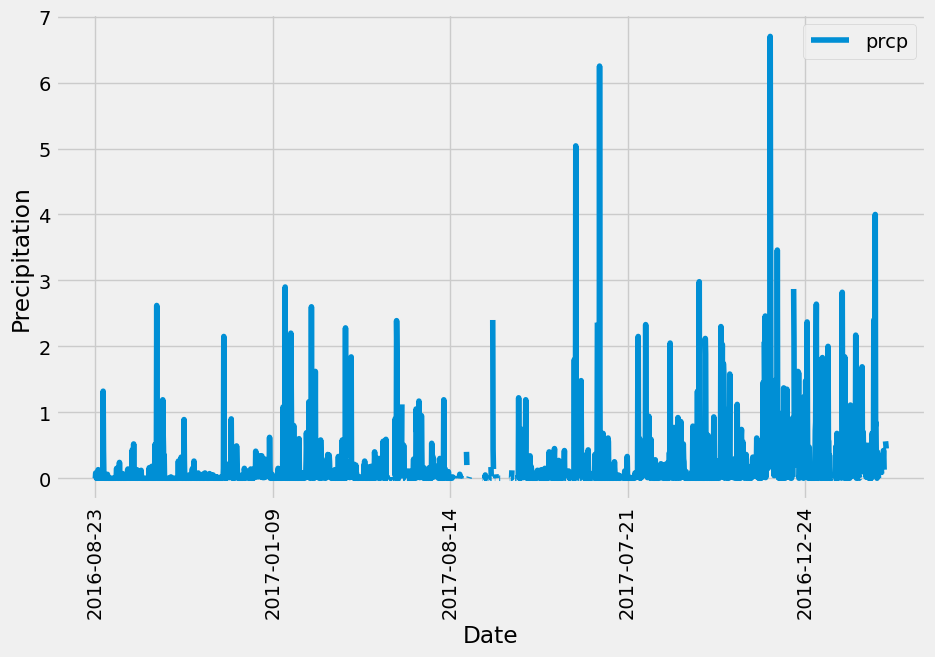

In [179]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta
# Calculate the date one year from the last date in data set.
one_year_ago = datetime.strptime(most_recent_date[0], '%Y-%m-%d')   - timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
tw_m_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(tw_m_data, columns=['date', 'prcp'])
# Sort the dataframe by date
df.set_index('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()


In [76]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [115]:
# Design a query to calculate the total number of stations in the dataset
sta_count = session.query(func.count(distinct(Station.id))).scalar()
sta_count

9

In [151]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).all()

most_active_stations = active_stations[0]

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

print(f"Most Active Station and it count: {most_active_stations}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511
Most Active Station and it count: ('USC00519281', 2772)


In [158]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_stations[0]).first()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_stations[0]).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_stations[0]).first()
print(f"Lowest temperature:{lowest_temp}")
print(f"Highest temperature:{highest_temp}")
print(f"Average temperature:{avg_temp}")

Lowest temperature:(54.0,)
Highest temperature:(85.0,)
Average temperature:(71.66378066378067,)


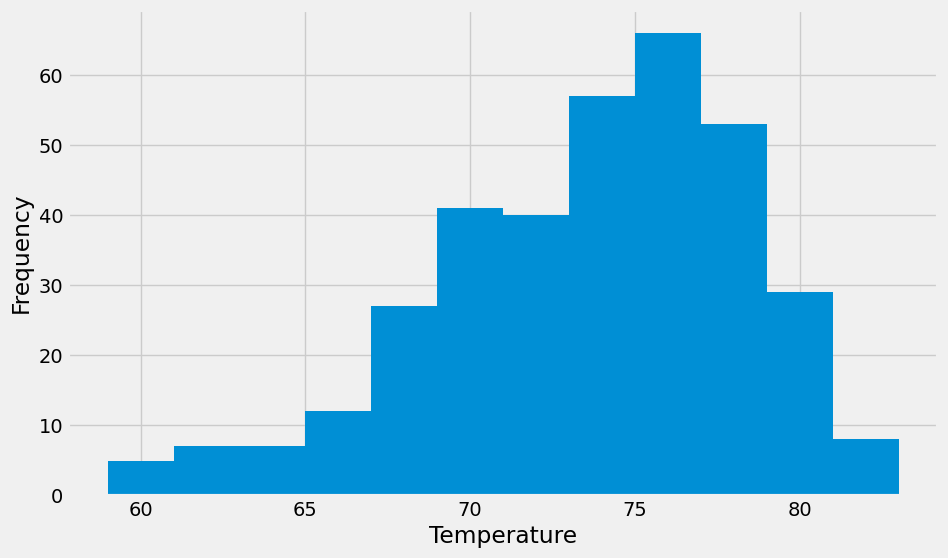

In [183]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_last_year = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_stations[0])\
        .filter(Measurement.date >= one_year_ago)\
            .all()
df_temp = pd.DataFrame(temp_last_year)
df_temp.set_index('tobs')
#Plot the result
plt.figure(figsize=(10, 6))
plt.hist(df_temp, bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [184]:
# Close Session
session.close()